For nomenclature, check README file of https://github.com/stanford-stagecast/stagecast-dev

Functions being called in this file are in the folder "functions_v8"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import time
import datetime

import sounddevice as sd
from scipy.io import wavfile

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions_v8')

from workflow import *
from read import *
from similarity import *
from helper import *
from display import *

In [2]:
# import session_info
# session_info.show()

In [3]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

In [4]:
samplerate, piano_audio = read_audio('Audio.wav')
if samplerate != 44100:
    print("Warning: Different sample rate - might cause issues in playing audio")
# sd.play(piano_audio, samplerate)

/Users/snehashah/Desktop/Stagecast/stagecast-dev/./functions_v8/read.py:53: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(filePath)


In [5]:
# sd.stop()

  Oops
  Oops


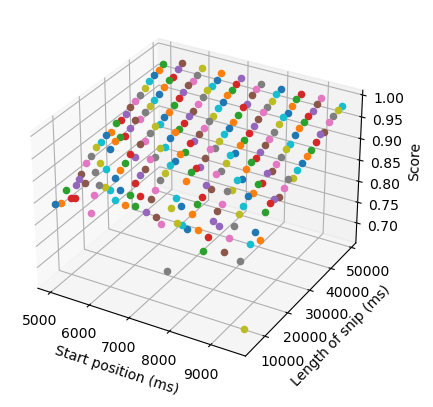

In [6]:
# Testing the above similarity algorithm with different snippets of different playthroughs that "should" have a good score
# Each pair of snippets below should have a GOOD similarity score!

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500): # x goes through different timestamps in a playthrough
#     print(x)
#     x = 0
    for y in range(5000,50000,2000): # y goes through different snippet lengths
        t1 = [y+x,0+x] # timestamps in ms of first playthrough
        t2 = [191400+y+x,191400+x] # timestamp in ms of second playthrough
#         t2 = [413000+y+x,413000+x] # timestamp in ms of thrid playthrough
#         t2 = [587000+y+x,587000+x] # timestamp in ms of fourth playthrough

        tf1 = time_to_sequence(notes, t1) # first snippet (here, y ms of first playthrough at time x)
        tf2 = time_to_sequence(notes, t2) # second snippet (here, y ms of second playthrough at time x)

        # calculating similarity of above snippets
        a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=False)
#         print(score)
        ax.scatter(x,y,score)
        if score<0.8:
            print("\t Oops")
#             a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=True)
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
#             play_match(piano_audio, t1[0],t1[1],t2[0],t2[1])
#             predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)

ax.set_xlabel('Start position (ms)')
ax.set_ylabel('Length of snip (ms)')
ax.set_zlabel('Score')
plt.show()

In [28]:
print(notes[-1][0])

729285


In [7]:
# Setting up parameters to run the matching algorithm

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000
disp = False

# Short time range for testing 
# start = 191400
# skip = 100
# end = 360000

fm = functools.partial(find_matches_at_timestamp, notes=notes, minNotes=minNotes, minTime=minTime, maxNotes=maxNotes, 
                       maxTime=maxTime, thresh=thresh, timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=disp)

# Running with time allocation to functions - analyse speed and bottlenecks
# %prun sims_arr.extend(find_matches_at_timestamp(25000, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))



In [8]:
# Running match algorithm parallely

# fm(25000)

# sims_arr = []
# curr_times = np.arange(start, end, skip)

# with Pool(4) as p:
#     sims_arr = p.map(fm, curr_times)

# # storing matches as array of all matches
# sarr = []
# for i in range(len(sims_arr)):
#     sarr.extend(sims_arr[i])

In [24]:
# Running match algorithm serially with target time following

# start measuring time to check v8 speedup amount
start_time = datetime.datetime.now()

sims_arr = [[]] # 2d array of all matches found (grouping matches for a single timestamp)
curr_times = np.arange(start, end, skip) # list of "current" times for which we are searching for matches
num_speedups = 0 # not currently being used; number of timestamps for which prev_matches tracking help improve speed

# Looping over source timestaps (timestamps for which we want to find matches)
for i in curr_times:
    if (i - start) % 100 == 0:
        print("At Timestamp: ",i)
    # Note: below funtion will only return matches with score > 0.5
    sims_arr.append(find_matches_at_timestamp_rev(i, notes, minNotes, minTime, maxNotes, maxTime, thresh=thresh, 
                        timestamp_max_before_source=timestamp_max_before_source, zero_penalty=zero_penalty, 
                        length_incentive=length_incentive, max_offset=max_offset, min_dist_const=min_dist_const, 
                        prev_matches=sims_arr[-1],disp=disp))

# converting sims_array (2d array) to a 1d array of matches
sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

# calculating time taken for above code to run
end_time = datetime.datetime.now()
timedelta = end_time-start_time
runtime = timedelta.total_seconds()
print("Ran in {:.2f} seconds, or {:.2f} minutes".format(runtime, runtime/60))

At Timestamp:  191400
i: 191400 i: 191410 i: 191420 

KeyboardInterrupt: 

In [ ]:
# simsDF_1 = simsDF_old
# simsDFall_1 = simsDFall_old
# simsDF_2 = simsDF_old
# simsDFall_2 = simsDFall_old
# simsDF_old = simsDF
# simsDFall_old = simsDFall


In [11]:
## choosing only significant scores and storing the new data in sims_plot

sarr = np.array(sarr)
sims_thresh = sarr * (sarr>thresh) # matches where score greater than a defined threshold

# creating dataframes for easy manipulation of data
simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<AxesSubplot:title={'center':'All matches >0.7, for \nMin Notes=8 notes, Max Notes=200'}, xlabel='source_timestamp', ylabel='target_timestamp'>

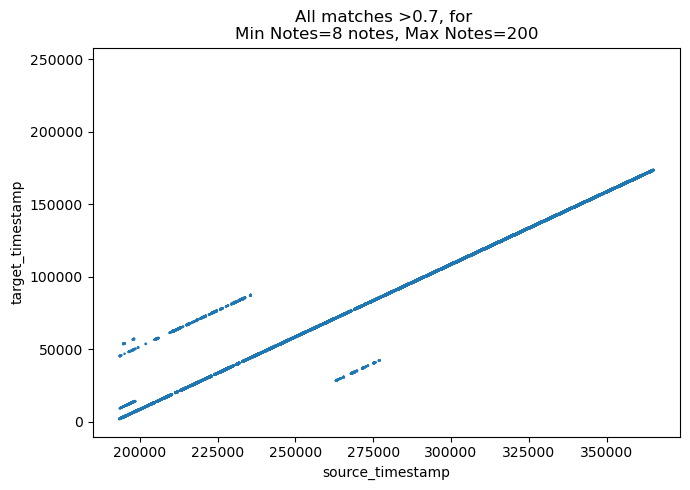

In [12]:
# plotting all matches with score > threshold
# plot of source timestamp vs target timestamp

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 98.8%
Percentage matches >0.7 found: 96.9%
Percentage matches within 50ms of line: 93.2%
Percentage matches >0.7 and within 50ms of the line: 91.9%
Minimum score of a "right match": 0.50



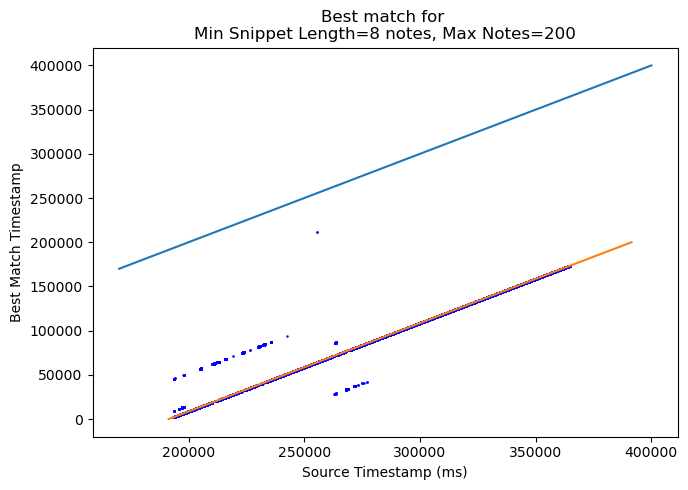

In [23]:
# Plotting best match only for each source timestamp
# plot of source timestamp vs target timestamp
# blue line is current playthrough (if match was found at current timestamp - not allowed)
# orange line is previous playthrough (corresponds to "expected match" if both playthroughs were identical)
# "on the line" refers to match very close to orange line; within acc ms

# Caluculating statistics of matches
percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
min_good_score = 1

# accuracy within which we want to plot distribution of notes 
# ms within which we consider match "on the line"
acc = 50

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

toPlot = simsDFall
# toPlot = simsDFall_old

# params calculated to use in subsequent plots
distribution_hist = [] # distribution of distance from line for matches "on the line"
distribution_all = [] # distance from line for matches "on the line" for each source timestamp
close_matches = [] # array of matches "on the line"
bestMatches = [] # array of only best matches for each source timestamp

# Looping over source timestamps (timestaps for which we have matches)
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   


# blue line is current playthrough (if match was found at current timestamp - not allowed)
plt.plot(np.arange(170000,400000),np.arange(170000,400000))
# orange line is previous playthrough (corresponds to "expected match" if both playthroughs were identical)
plt.plot(np.arange(191400,391400),np.arange(200000))

total = len(curr_times) # Total number of source timestamps
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))
print()
# print("Number of loops sped up: {:d}".format(num_speedups))
# print("Percentage loops sped up: {:.2f} - rough estimate".format((num_speedups/(len(curr_times)))*100))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


Distribution Mean:-1.49
Distribution Standad Deviation:9.17


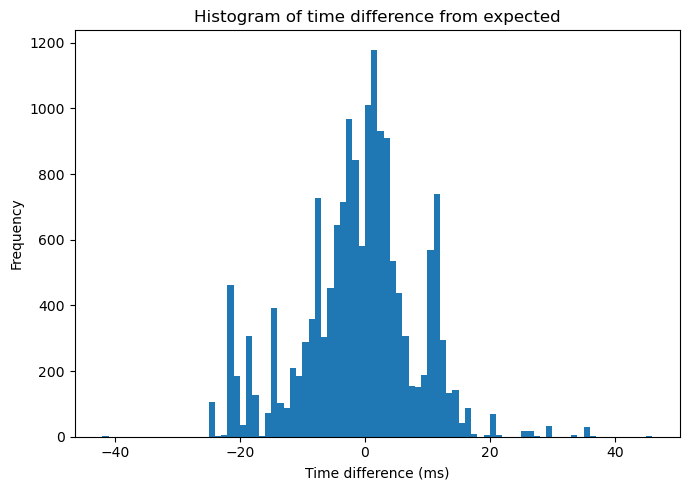

In [14]:
# plotting histogram of notes "on the line"
# OR plotting distance from the line for a "correct match"
# OR plotting difference between "correct match" and "expected match"
mean = np.mean(distribution_hist)
std = np.std(distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(distribution_hist,bins=int(max(distribution_hist)-min(distribution_hist)))
plt.title("Histogram of time difference from expected")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

Distribution Mean:5.05
Distribution Standad Deviation:29.32


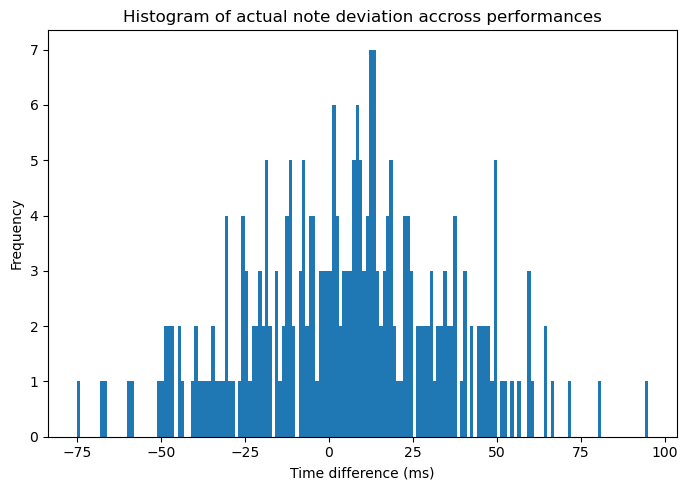

In [15]:
# Note distribution in first vs second playthrough

note_distribution_hist = []
for note in notes[time_to_index(notes,start):time_to_index(notes,end)]:
    # find closest note in history
    note2 = find_note(notes, note[0]-191400, note[1], max_time_dist = 100)
    if note2:
        note_distribution_hist.append(note[0]-notes[note2][0]-191400)
    
mean = np.mean(note_distribution_hist)
std = np.std(note_distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(note_distribution_hist,bins=int(max(note_distribution_hist)-min(note_distribution_hist)))
plt.title("Histogram of actual note deviation accross performances")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

(16175, 9)
source_timestamp    193470.000000
target_timestamp      2067.000000
score                    0.715674
source_id_start        766.000000
source_id_end          758.000000
target_id_start          6.000000
target_id_end            2.000000
match_len                8.000000
match_time            1796.000000
deviation               -3.000000
Name: 0, dtype: float64
(1, 10)
[[195210   3856      0    771    758     15      2     13   3536     46]]
[195210   3856      0    771    758     15      2     13   3536     46]


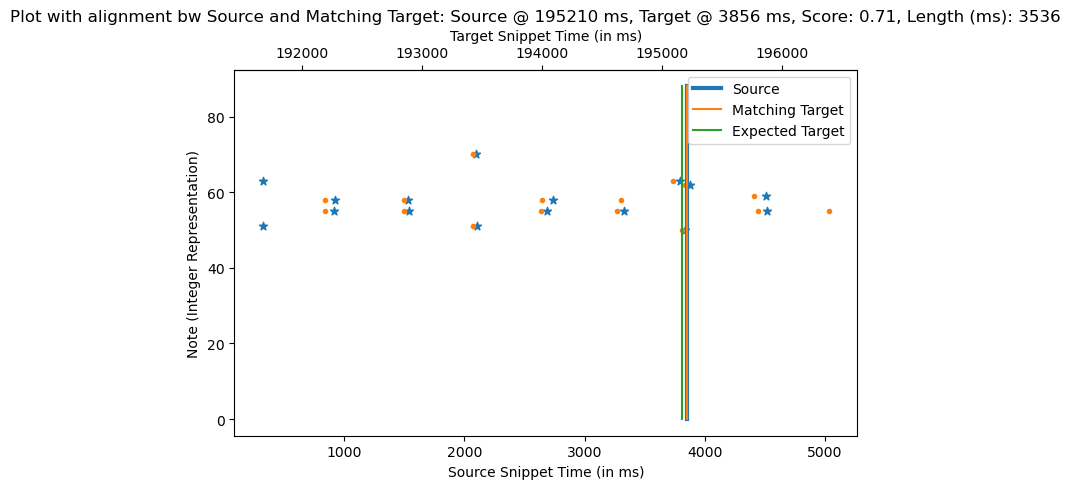

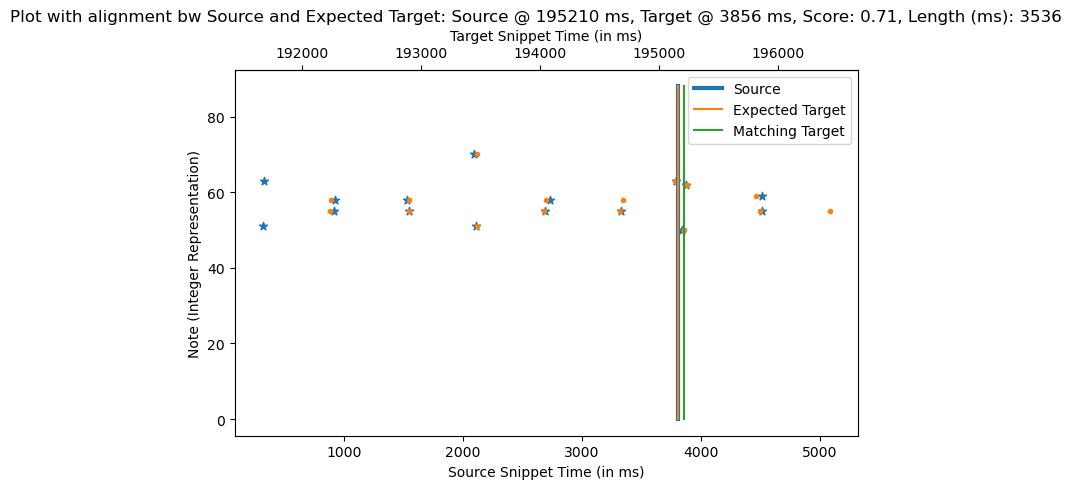

Source end notes:
 [[195144     63     44]
 [195191     50     40]
 [195230     62     56]
 [195868     59     41]
 [195870     55     45]]
Source end notes - 191400: [3744 3791 3830 4468 4470]
Target end notes:
 [[3810   50   49]
 [3832   62   61]
 [4414   59   45]
 [4446   55   49]
 [5035   55   45]]
Source diff between notes: [ 47  39 638   2]
Target diff between notes: [ 22 582  32 589]
Source time - last note: 19.0
Target time - last note: 24.0



In [16]:
# Plotting k worst matches - matches on the line but farthest from it

#['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
k = 1

# dtype = [('source_timestamp', float), ('target_timestamp', float), ('score', float),('source_id_start', float),\
#          ('source_id_end', float),('target_id_start', float),('target_id_end', float),('match_len', float),('match_time', float)]

close_matches_array = np.array(close_matches)
distribution_hist_array = np.array(distribution_hist)
print(close_matches_array.shape)
close_matches_df = pd.DataFrame(data = close_matches_array, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
close_matches_df['deviation'] = distribution_hist_array

close_matches_sorted = close_matches_df.sort_values(by=['deviation'])

worst_matches = np.array(close_matches_sorted.iloc[-k:],dtype=float)

print(close_matches_df.iloc[0])
print(worst_matches.shape)
print(worst_matches.astype(int))
for match in worst_matches:
    print(match.astype(int))
    source_start = int(match[0])
    target_start = int(match[1])
    score = match[2]
    source_id_start = int(match[3])
    source_id_end = int(match[4])
    target_id_start = int(match[5])
    target_id_end = int(match[6])
    match_len = int(match[7])
    match_time = int(match[8])
    
    # plot worst match (in terms of distance from expected timestamp)
    diff = source_start - target_start
    sequence1 = np.copy(notes[source_id_end:source_id_start+3])
    sequence1[:,0] = sequence1[:,0]-diff
    sequence2 = np.copy(notes[target_id_end:target_id_start+3])
    sequence2[:,0] = sequence2[:,0]
    sequence3 = sequence2.copy()
    sequence3[:,0] = sequence2[:,0]-diff+191400
    
    display_expected_actual(sequence1,sequence2,source_start,target_start,source_start-diff,target_start,source_start-191400,diff,score,match_time,l1="Source",l2="Matching Target",l3="Expected Target")
    display_expected_actual(sequence1,sequence3,source_start,target_start,source_start-191400,source_start-191400,target_start,diff,score,match_time,l1="Source",l2="Expected Target",l3="Matching Target")
    
    a = notes[source_id_start-2:source_id_start+3]
    b = notes[target_id_start-2:target_id_start+3]
    print("Source end notes:\n",a)
    print("Source end notes - 191400:",a[:,0] - 191400)
    print("Target end notes:\n",b)
    print("Source diff between notes:",a[1:,0] - a[:-1,0])
    print("Target diff between notes:",b[1:,0] - b[:-1,0])
    print("Source time - last note:",match[0]-notes[int(match[3])-1][0])
    print("Target time - last note:",match[1]-notes[int(match[5])-1][0])
    print()

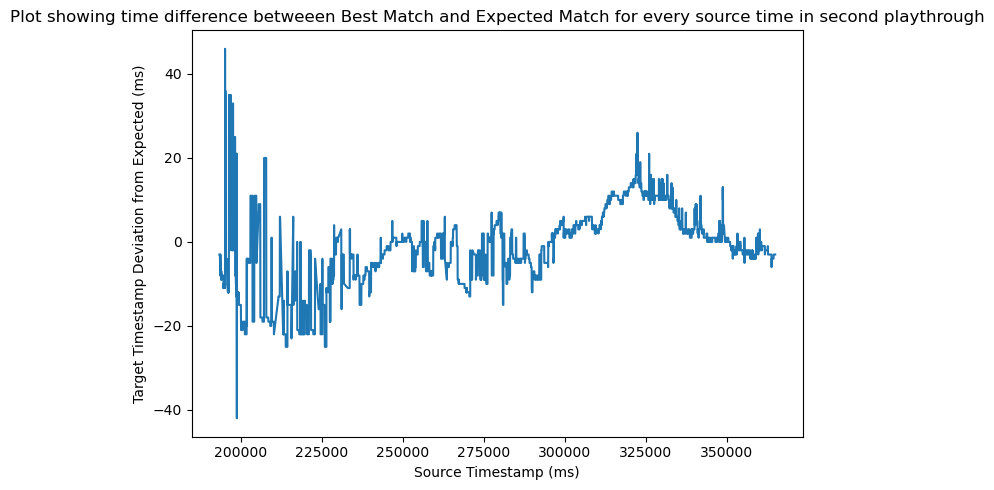

In [26]:
# Plotting distance from line vs source time

distribution_all_arr = np.array(distribution_all)
plt.plot(distribution_all_arr[:,0],distribution_all_arr[:,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match for every source time in second playthrough")
plt.show()

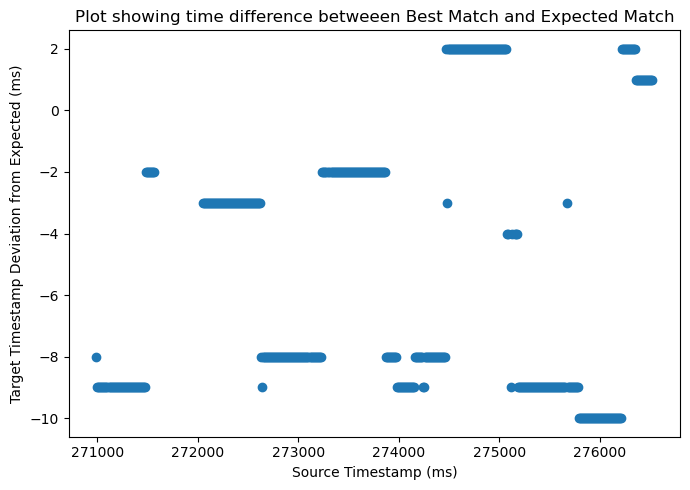

In [18]:
# Plotting distance from line vs source time - within a range of source timestamps

source_time = 275000
index = (source_time - start)//skip
index -= 1500
len_match = 500

# Getting match details near source time we're interested in
# Can use this to make display_snippet plots
# matches_near_source = np.array(close_matches_df.iloc[index:index+500])

distribution_all_arr = np.array(distribution_all)
plt.scatter(distribution_all_arr[index:index+len_match,0],distribution_all_arr[index:index+len_match,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match")
plt.show()

In [19]:
# used for legend in below plots
pop_a = mpatches.Patch(color='blue', label='Unexpected match')
pop_b = mpatches.Patch(color='orange', label='On the line match')

207


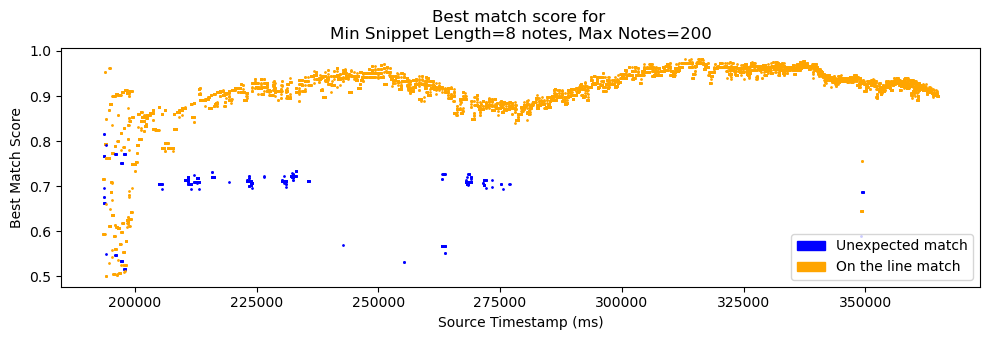

In [20]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in curr_times:
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    else:
        if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
            color = 'orange'
        else:
            color = 'blue'
        plt.scatter(x,y,1,c=color) # need to include s (len of best match)

# currDF = simsDFall.copy()
# currDF.sort_values(['source_timestamp', 'score', 'match_len'], ascending=[True, False, False]).drop_duplicates(['source_timestamp']).reset_index(drop=True)
# plt.scatter(curr_times,currDF.loc[currDF['source_timestamp'] == curr_times]['score'],currDF.loc[currDF['source_timestamp'] == curr_times]['match_len'])
# scores = s.max(axis = 0)
# # if np.isnan(y):
# #     count += 1
# #     y = 0
    

print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.legend(handles=[pop_a,pop_b])
plt.show()

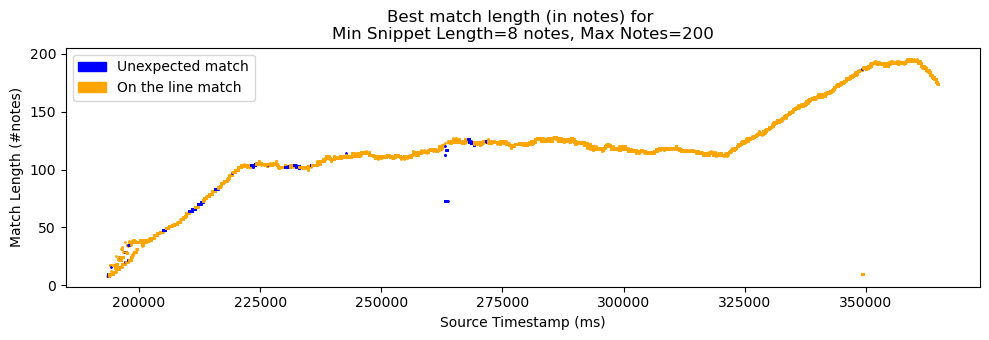

In [21]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.legend(handles=[pop_a,pop_b])
plt.show()

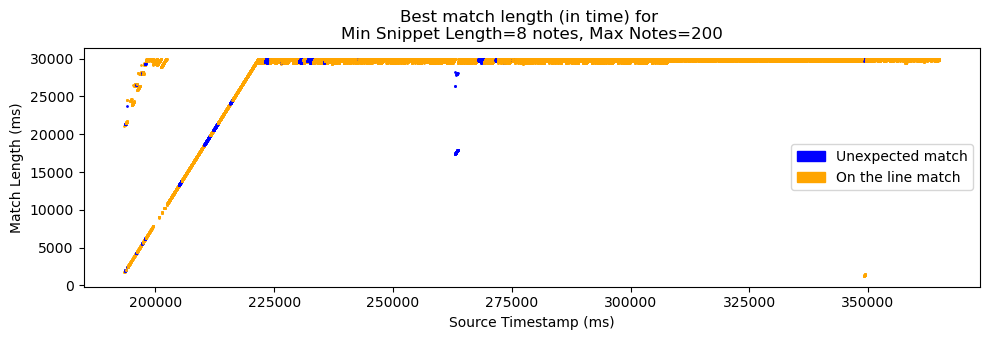

In [22]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_time'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.legend(handles=[pop_a,pop_b])
plt.show()